In [1]:
import vrpSolver

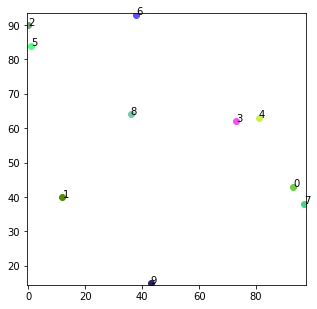

In [2]:
# Generate instance
nodes = vrpSolver.rndPlainNodes(N = 10)
fig, ax = vrpSolver.plotNodes(
    nodes = nodes)

In [3]:
# DFJ with lazy cut
DFJ_Lazy = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_Lazy")
print(DFJ_Lazy)

Academic license - for non-commercial use only
{'ofv': 291.9859872838885, 'seq': [0, 4, 3, 8, 6, 2, 5, 1, 9, 7, 0], 'gap': 0, 'lowerBound': 291.9859872838885, 'upperBound': 291.9859872838885, 'runtime': 0.0029964447021484375, 'fml': 'DFJ_Lazy'}


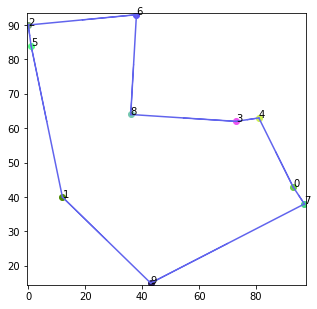

In [4]:
# Plot the result of TSP
vrpSolver.plotSeq(
    fig = fig,
    ax = ax,
    nodes=nodes, 
    seq=DFJ_Lazy['seq'])
fig

In [5]:
# DFJ with plain loop
DFJ_PlainLoop = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "DFJ_PlainLoop")
print(DFJ_PlainLoop)

{'ofv': 291.9859872838885, 'seq': [0, 4, 3, 8, 6, 2, 5, 1, 9, 7, 0], 'gap': 0, 'lowerBound': 291.9859872838885, 'upperBound': 291.9859872838885, 'runtime': 0.0030422210693359375, 'fml': 'DFJ_PlainLoop'}


In [6]:
# MTZ
MTZ = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MTZ")
print(MTZ)

{'ofv': 291.9859872838885, 'seq': [0, 7, 9, 1, 5, 2, 6, 8, 3, 4, 0], 'gap': 0, 'lowerBound': 291.9859872838885, 'upperBound': 291.9859872838885, 'runtime': 0.05800056457519531, 'fml': 'MTZ'}


In [7]:
# MultiCommodityFlow
MultiCommodityFlow = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "MultiCommodityFlow")
print(MultiCommodityFlow)

{'ofv': 291.9859872838885, 'seq': [0, 4, 3, 8, 6, 2, 5, 1, 9, 7, 0], 'gap': 0, 'lowerBound': 291.9859872838885, 'upperBound': 291.9859872838885, 'runtime': 0.013010025024414062, 'fml': 'MultiCommodityFlow'}


In [8]:
# ShortestPath
ShortestPath = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "ShortestPath")
print(ShortestPath)

{'ofv': 291.9859872838885, 'seq': [0, 4, 3, 8, 6, 2, 5, 1, 9, 7, 0], 'gap': 0, 'lowerBound': 291.9859872838885, 'upperBound': 291.9859872838885, 'runtime': 0.03700065612792969, 'fml': 'ShortestPath'}


In [9]:
# QAP
QAP = vrpSolver.ipTSP(
    nodes = nodes, 
    fml = "QAP")
print(QAP)

{'ofv': 291.9859872838885, 'seq': [8, 3, 4, 0, 7, 9, 1, 5, 2, 6, 8], 'gap': 0, 'lowerBound': 291.9859872838885, 'upperBound': 291.9859872838885, 'runtime': 2.5123939514160156, 'fml': 'QAP'}
